In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

In [2]:
with open("../ptu_derep/derep_plasmids_ids.txt") as f:
    plasmids = [
        i.strip() if "IMGPR" not in i else i.strip().split("|")[0]
        for i in f.readlines()
    ]

In [3]:
with duckdb.connect("../soil_plasmid.db") as con:
    df_n_genes_genomad = con.execute("SELECT * FROM genomad_results").df()
    df_n_genes_genomad.set_index("seq_name", inplace=True)

# df_n_genes_genomad = pd.read_csv(
#     "../all_plasmid_with_isolates_summary_filtered_final.tsv", sep="\t", index_col=0
# )
n_genes_genomad = df_n_genes_genomad["n_genes"]
# df_n_genes.head()

In [4]:
df_n_genes_imgpr = pd.read_csv(
    "../IMGPR_plasmid_data/IMGPR_plasmid_soil_data.tsv", sep="\t", index_col=0
)
n_genes_imgpr = df_n_genes_imgpr["gene_count"]
# df_n_genes_imgpr.head()

In [5]:
with duckdb.connect("../soil_plasmid.db") as con:
    df = con.execute("SELECT Query_name, Hit_name FROM hmm_outputs").df()
    df_eggnog = con.execute(
        "SELECT query,seed_ortholog FROM eggnog WHERE COG_category !='-' AND COG_category != 'S' AND COG_category != 'R'"
    ).df()
    df_ptu = con.execute("SELECT * FROM ptu_derep").df()

df_eggnog.columns = ["Hit_name", "Query_name"]
df = pd.concat([df, df_eggnog])

In [6]:
df.head()

,Query_name,Hit_name
0,K05847,3300025728|Ga0207655_1000049_228
1,K05847,3300025728|Ga0207655_1000238_50
2,K05874,3300025735|Ga0207713_1000116_91
3,K05877,3300025728|Ga0207655_1000850_32
4,K05877,3300025735|Ga0207713_1000020_142


In [7]:
df["Plasmid"] = df["Hit_name"].apply(
    lambda x: "_".join(x.split("_")[0:-1]) if "IMGPR" not in x else x.split("|")[0]
)

In [8]:
df = df[df["Plasmid"].isin(plasmids)]

In [9]:
df_n_genes = (
    df.groupby("Plasmid")["Hit_name"]
    .nunique()
    .to_frame()
    .join(pd.concat([n_genes_genomad, n_genes_imgpr]).to_frame())
    .rename(columns={"Hit_name": "genes_with_prediction", 0: "n_genes"})
)
df_n_genes.head()

,genes_with_prediction,n_genes
Plasmid,,
2088090014|GPIPI_16557027,3,10
2088090014|GPIPI_16884012,4,12
2088090014|GPIPI_16944593,5,6
2088090014|GPIPI_17035422,1,6
2088090014|GPIPI_17320127,4,6


In [ ]:
df_n_genes.reset_index(inplace=True)
df_n_genes["prediction_fraction"] = (
    df_n_genes["genes_with_prediction"] / df_n_genes["n_genes"]
)
df_n_genes["Origin"] = df_n_genes["Plasmid"].apply(
    lambda x: "Isolate"
    if any(i for i in ["IMGPR", "Refsoil", "PLSDB"] if i in x)
    else "Meta"
)


df_n_genes["prediction_fraction"] = df_n_genes["prediction_fraction"].apply(
    lambda x: x if x <= 1 else 1.0
)  # for some reason there is one plasmid with prediction fraction higher than 1
df_n_genes.head()

,Plasmid,genes_with_prediction,n_genes,prediction_fraction,Origin
0,2088090014|GPIPI_16557027,3,10,0.300000,Meta
1,2088090014|GPIPI_16884012,4,12,0.333333,Meta
2,2088090014|GPIPI_16944593,5,6,0.833333,Meta
3,2088090014|GPIPI_17035422,1,6,0.166667,Meta
4,2088090014|GPIPI_17320127,4,6,0.666667,Meta


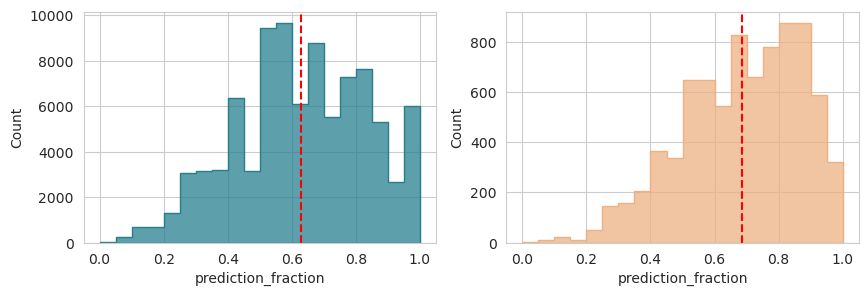

In [18]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)

sns.histplot(
    data=df_n_genes[df_n_genes["Origin"] == "Meta"],
    x="prediction_fraction",
    ax=axes[0],
    element="step",
    binrange=(0, 1),
    binwidth=0.05,
    color="#277F8E",
)
axes[0].axvline(
    x=df_n_genes[df_n_genes["Origin"] == "Meta"]["prediction_fraction"].mean(),
    color="red",
    linestyle="--",
)
sns.histplot(
    data=df_n_genes[df_n_genes["Origin"] == "Isolate"],
    x="prediction_fraction",
    ax=axes[1],
    element="step",
    binrange=(0, 1),
    binwidth=0.05,
    color="#EDB183",
)
axes[1].axvline(
    x=df_n_genes[df_n_genes["Origin"] == "Isolate"]["prediction_fraction"].mean(),
    color="red",
    linestyle="--",
)
fig.savefig("../figures/plasmid_gene_prediction_fraction.pdf", bbox_inches="tight")

In [15]:
df_n_genes[df_n_genes["Origin"] == "Isolate"]["prediction_fraction"].mean()

0.6856593040246444

In [17]:
df_n_genes[df_n_genes["Origin"] == "Meta"]["prediction_fraction"].mean()

0.6290408817569857

In [29]:
from scipy import stats

stats.mannwhitneyu(
    df_n_genes[df_n_genes["Origin"] == "Meta"]["prediction_fraction"],
    df_n_genes[df_n_genes["Origin"] == "Isolate"]["prediction_fraction"],
)

MannwhitneyuResult(statistic=303000576.5, pvalue=1.0299188352289919e-137)

Pra cada PTU, ver se tem meta e isolado. E fazer um histograma dos diferentes países

In [30]:
df_env = pd.read_csv("../env_corr/taxon_countries.tsv", sep="\t")
df_env["taxon_oid"] = df_env["taxon_oid"].astype(str)
df_env.set_index("taxon_oid", inplace=True)
df_env.head()

,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),...,soc (dg/kg),PTU Count,geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
taxon_oid,,,,,,,,,,,,,,,,,,,,,
3300049023,Grasslands,38.53,-121.78,Meta,USA,Grasslands,36,Luvisols,152.0,252.0,...,335.0,27.0,POINT (-121.78 38.53),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"
3300012840,Grasslands,43.07,-89.40,Meta,USA,Grasslands,21,Luvisols,NaN,NaN,...,NaN,18.0,POINT (-89.4 43.07),187.0,Prairie-Forest Border,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests
3300039503,Unclassified,63.88,-149.23,Meta,USA,Unclassified,3,Cambisols,60.0,541.0,...,2409.0,2.0,POINT (-149.23 63.88),734.0,Alaska Range,NaN,NA6,Nearctic,6.0,Boreal Forests/Taiga
3300042005,Rhizosphere,41.20,-97.94,Meta,USA,Rhizosphere,6,Kastanozems,135.0,182.0,...,301.0,6.0,POINT (-97.94 41.2),747.0,Central Mixed-Grass Prairie,NaN,NA8,Nearctic,8.0,"Temperate Grasslands, Savannas and Shrublands"
3300049265,Agricultural land,38.55,-121.87,Meta,USA,Agricultural land,1,Vertisols,158.0,235.0,...,274.0,1.0,POINT (-121.87 38.55),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"


In [65]:
from collections import defaultdict


ptu_country_mapping = defaultdict(list)
# df_ptu.set_index('PTU', inplace=True)

for idx, row in df_ptu[df_ptu["Length"] > 1].iterrows():
    for oid in row["oids"].split(","):
        try:
            ptu_country_mapping[idx].append(df_env.loc[oid, "Isolation Country"])
        except KeyError:
            ptu_country_mapping[idx].append("Unknown")

In [66]:
for k, v in ptu_country_mapping.items():
    ptu_country_mapping[k] = list(set(v))

In [67]:
df_ptu["Origin"].to_frame()

,Origin
PTU,
PTU-00000,Meta
PTU-00001,Meta
PTU-00002,Meta
PTU-00003,Meta
PTU-00004,Meta
...,...
PTU-57260,Meta
PTU-57261,Meta
PTU-57262,Meta


In [68]:
ptu_countries_df = pd.DataFrame(
    ptu_country_mapping.items(), columns=["PTU", "Countries"]
)

ptu_countries_df["n_countries"] = ptu_countries_df["Countries"].apply(
    lambda x: len([i for i in x if not isinstance(i, float)])
)
ptu_countries_df = ptu_countries_df.join(df_ptu["Origin"].to_frame(), on="PTU")

<Axes: xlabel='n_countries', ylabel='Percent'>

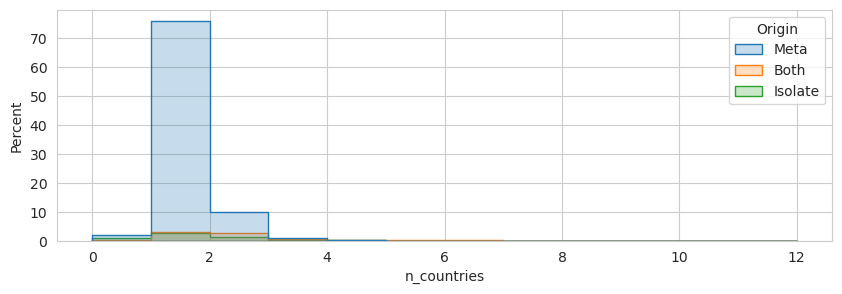

In [72]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.histplot(
    data=ptu_countries_df,
    x="n_countries",
    ax=ax,
    element="step",
    stat="percent",
    binrange=(0, 12),
    binwidth=1,
    hue="Origin",
)

In [74]:
ptu_countries_df

,PTU,Countries,n_countries,Origin
0,PTU-00000,"[nan, Australia, Canada, USA, Sweden, Germany]",5,Meta
1,PTU-00001,"[USA, Sweden, Puerto Rico, nan]",3,Meta
2,PTU-00002,"[USA, United Kingdom]",2,Meta
3,PTU-00003,"[nan, Senegal, Australia, USA, Sweden]",4,Meta
4,PTU-00004,"[USA, Sweden, Australia, Germany]",4,Meta
...,...,...,...,...
15202,PTU-15202,[USA],1,Meta
15203,PTU-15203,[USA],1,Meta
15204,PTU-15204,"[nan, Germany]",1,Isolate
15205,PTU-15205,[USA],1,Meta


<Axes: xlabel='n_countries', ylabel='Percent'>

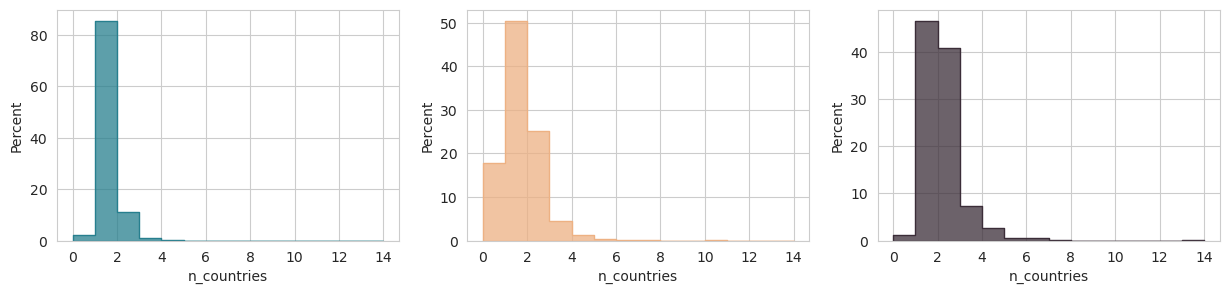

In [81]:
fig, axes = plt.subplots(figsize=(15, 3), ncols=3)

sns.histplot(
    data=ptu_countries_df[ptu_countries_df["Origin"] == "Meta"],
    x="n_countries",
    ax=axes[0],
    element="step",
    stat="percent",
    binrange=(0, 14),
    binwidth=1,
    color="#277F8E",
)

sns.histplot(
    data=ptu_countries_df[ptu_countries_df["Origin"] == "Isolate"],
    x="n_countries",
    ax=axes[1],
    element="step",
    stat="percent",
    binrange=(0, 14),
    binwidth=1,
    color="#EDB183",
)
sns.histplot(
    data=ptu_countries_df[ptu_countries_df["Origin"] == "Both"],
    x="n_countries",
    ax=axes[2],
    element="step",
    stat="percent",
    binrange=(0, 14),
    binwidth=1,
    color="#3B2D38",
)

comparar os plasmídeos de meta. Separando em dois grupos: os que estão em PTU só de meta, e os que estão em PTU com isolado. Não contar os países dos isolados

In [84]:
ptu_ns_df = df_ptu[df_ptu["Length"] > 1]

In [88]:
ptu_country_mapping_2 = defaultdict(list)
# df_ptu.set_index('PTU', inplace=True)

for idx, row in df_ptu[df_ptu["Length"] > 1].iterrows():
    for oid, p_origin in zip(row["oids"].split(","), row["Full_origin"].split(";")):
        if p_origin == "Meta":
            try:
                ptu_country_mapping_2[idx].append(df_env.loc[oid, "Isolation Country"])
            except KeyError:
                ptu_country_mapping_2[idx].append("Unknown")

ptu_country_mapping_2 = {k: list(set(v)) for k, v in ptu_country_mapping_2.items()}

In [122]:
ptu_countries_df2 = pd.DataFrame(
    ptu_country_mapping_2.items(), columns=["PTU", "Countries"]
)

ptu_countries_df2["n_countries"] = ptu_countries_df2["Countries"].apply(
    lambda x: len([i for i in x if not isinstance(i, float)])
)
ptu_countries_df2 = ptu_countries_df2.join(df_ptu["Origin"].to_frame(), on="PTU")
ptu_countries_df2["n_countries"] = ptu_countries_df2["n_countries"].replace(0, 1)
ptu_countries_df2.head()

,PTU,Countries,n_countries,Origin
0,PTU-00000,"[nan, Australia, Canada, USA, Sweden, Germany]",5,Meta
1,PTU-00001,"[USA, Sweden, Puerto Rico, nan]",3,Meta
2,PTU-00002,"[USA, United Kingdom]",2,Meta
3,PTU-00003,"[nan, Senegal, Australia, USA, Sweden]",4,Meta
4,PTU-00004,"[USA, Sweden, Australia, Germany]",4,Meta


<Axes: xlabel='n_countries', ylabel='Percent'>

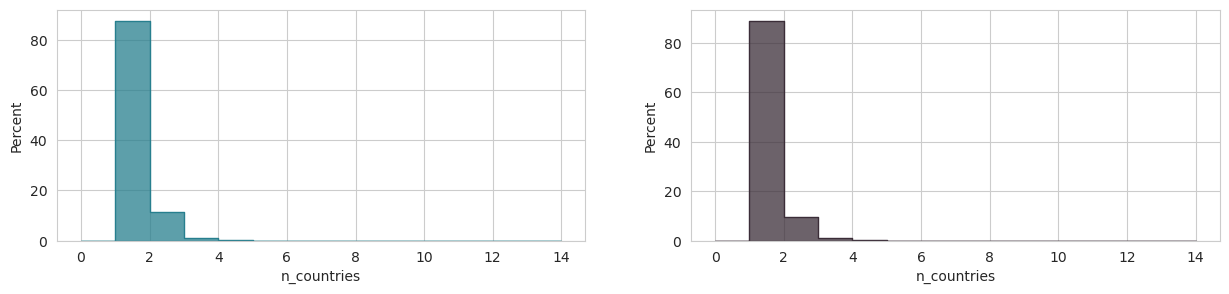

In [123]:
fig, axes = plt.subplots(figsize=(15, 3), ncols=2)

sns.histplot(
    data=ptu_countries_df2[ptu_countries_df2["Origin"] == "Meta"],
    x="n_countries",
    ax=axes[0],
    element="step",
    stat="percent",
    binrange=(0, 14),
    binwidth=1,
    color="#277F8E",
)

sns.histplot(
    data=ptu_countries_df2[ptu_countries_df2["Origin"] == "Both"],
    x="n_countries",
    ax=axes[1],
    element="step",
    stat="percent",
    binrange=(0, 14),
    binwidth=1,
    color="#3B2D38",
)

In [142]:
ptu_countries_df2[ptu_countries_df2["Origin"] == "Meta"]["n_countries"].mean()

1.1357851117359774

Vamos pegar os clusters de derreplicação. A ideia agora é  pegar os plasmídeos idênticos aos de isolado e ver a distribuição, na expectativa que eles são encontrados em menos lugares do que os plasmídeos de meta que não são idênticos aos de isolado

In [98]:
df_drep = pd.read_csv(
    "../ptu/derep/all_soil_plasmids_final_clusters.tsv", sep="\t", header=None
)
df_drep.columns = ["Representative", "Identical_plasmids"]
df_drep.head()

,Representative,Identical_plasmids
0,3300056791|Ga0562384_00437,"3300056791|Ga0562384_00437,3300050130|Ga050001..."
1,3300049049|Ga0498755_000002,"3300049049|Ga0498755_000002,3300049210|Ga04987..."
2,3300048762|Ga0494703_000498,"3300048762|Ga0494703_000498,3300047662|Ga04972..."
3,MGYA00645639|ERZ12343768.66-NODE-68-length-484...,MGYA00645639|ERZ12343768.66-NODE-68-length-484...
4,3300046463|Ga0495653_0004205,"3300046463|Ga0495653_0004205,3300046477|Ga0495..."


In [131]:
def get_origin(row):
    plasmids = row["Identical_plasmids"].split(",")
    origin = []
    for plasmid in plasmids:
        if any(i for i in ["IMGPR", "PLSDB", "Refsoil"] if i in plasmid):
            origin.append("Isolate")
        else:
            origin.append("Meta")
    return origin


def get_oids(row):
    plasmids = row["Identical_plasmids"].split(",")
    oids = []
    for plasmid in plasmids:
        if "IMGPR" not in plasmid:
            oids.append(plasmid.split("|")[0])
        else:
            oids.append(plasmid.split("_")[2])
    return oids


df_drep["Full_origin"] = df_drep.apply(get_origin, axis=1)
df_drep["Origin"] = df_drep["Full_origin"].apply(
    lambda x: "Both" if "Meta" in x and "Isolate" in x else x[0]
)
df_drep["Length"] = df_drep["Identical_plasmids"].apply(lambda x: len(x.split(",")))
df_drep["oids"] = df_drep.apply(get_oids, axis=1)
df_drep = df_drep[df_drep["Length"] > 1]
df_drep.head()

,Representative,Identical_plasmids,Full_origin,Origin,Length,oids
0,3300056791|Ga0562384_00437,"3300056791|Ga0562384_00437,3300050130|Ga050001...","[Meta, Meta, Meta, Meta, Meta, Meta, Meta, Met...",Meta,27,"[3300056791, 3300050130, 3300048810, 330004876..."
1,3300049049|Ga0498755_000002,"3300049049|Ga0498755_000002,3300049210|Ga04987...","[Meta, Meta, Meta, Meta, Meta, Meta, Meta, Met...",Meta,25,"[3300049049, 3300049210, 3300049209, 330004905..."
2,3300048762|Ga0494703_000498,"3300048762|Ga0494703_000498,3300047662|Ga04972...","[Meta, Meta, Meta, Meta, Meta, Meta, Meta, Met...",Meta,23,"[3300048762, 3300047662, 3300048814, 330004876..."
3,MGYA00645639|ERZ12343768.66-NODE-68-length-484...,MGYA00645639|ERZ12343768.66-NODE-68-length-484...,"[Meta, Meta, Meta, Meta, Meta, Meta, Meta, Met...",Meta,22,"[MGYA00645639, MGYA00645693, MGYA00645526, MGY..."
4,3300046463|Ga0495653_0004205,"3300046463|Ga0495653_0004205,3300046477|Ga0495...","[Meta, Meta, Meta, Meta, Meta, Meta, Meta, Met...",Meta,22,"[3300046463, 3300046477, 3300046516, 330004651..."


In [132]:
df_env_underep = pd.read_csv("soil_plasmids_map_before_derep.tsv", sep="\t")
df_env_underep["taxon_oid"] = df_env_underep["taxon_oid"].astype(str)
df_env_underep.set_index("taxon_oid", inplace=True)
df_env_underep.head()

,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),PTU Count
taxon_oid,,,,,,,,,,,,,,,,,,,
3300049023,Grasslands,38.53,-121.78,Meta,USA,Grasslands,36,Luvisols,152.0,252.0,4.0,267.0,395.0,332.0,69.0,171.0,562.0,335.0,27.0
3300012840,Grasslands,43.07,-89.40,Meta,USA,Grasslands,21,Luvisols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
3300039503,Unclassified,63.88,-149.23,Meta,USA,Unclassified,3,Cambisols,60.0,541.0,112.0,137.0,1084.0,670.0,49.0,367.0,496.0,2409.0,2.0
3300042005,Rhizosphere,41.20,-97.94,Meta,USA,Rhizosphere,6,Kastanozems,135.0,182.0,3.0,163.0,299.0,377.0,63.0,594.0,242.0,301.0,6.0
3300049265,Agricultural land,38.55,-121.87,Meta,USA,Agricultural land,1,Vertisols,158.0,235.0,8.0,297.0,253.0,330.0,69.0,195.0,508.0,274.0,1.0


In [133]:
drep_country_mapping = defaultdict(list)

for idx, row in df_drep.iterrows():
    for oid, p_origin in zip(row["oids"], row["Full_origin"]):
        if p_origin == "Meta":
            try:
                drep_country_mapping[idx].append(
                    df_env_underep.loc[oid, "Isolation Country"]
                )
            except KeyError:
                drep_country_mapping[idx].append("Unknown")

drep_country_mapping = {k: list(set(v)) for k, v in drep_country_mapping.items()}

In [134]:
drep_country_df = pd.DataFrame(
    drep_country_mapping.items(), columns=["Group", "Countries"]
)
drep_country_mapping["n_countries"] = drep_country_df["Countries"].apply(
    lambda x: len([i for i in x if not isinstance(i, float)])
)
drep_country_df["n_countries"] = drep_country_mapping["n_countries"].replace(0, 1)
drep_country_df = drep_country_df.join(df_drep["Origin"].to_frame(), on="Group")
drep_country_df.head()

,Group,Countries,n_countries,Origin
0,0,[Sweden],1,Meta
1,1,[USA],1,Meta
2,2,[Sweden],1,Meta
3,3,[nan],1,Meta
4,4,[USA],1,Meta


<Axes: xlabel='n_countries', ylabel='Percent'>

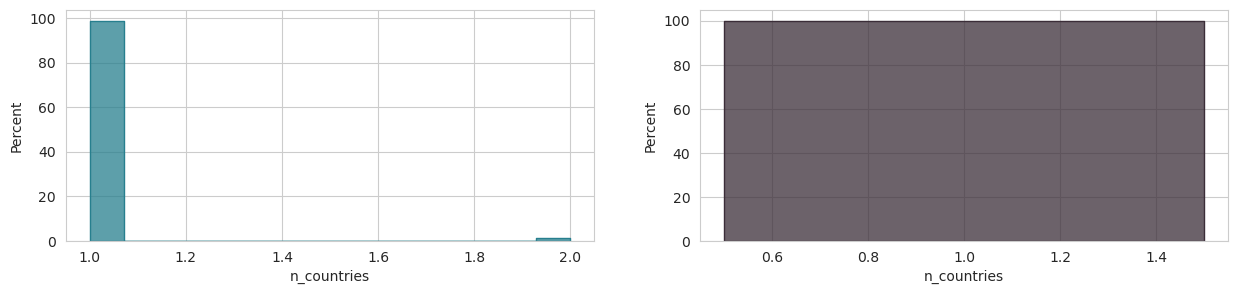

In [137]:
fig, axes = plt.subplots(figsize=(15, 3), ncols=2)

sns.histplot(
    data=drep_country_df[drep_country_df["Origin"] == "Meta"],
    x="n_countries",
    ax=axes[0],
    element="step",
    stat="percent",
    color="#277F8E",
)

sns.histplot(
    data=drep_country_df[drep_country_df["Origin"] == "Both"],
    x="n_countries",
    ax=axes[1],
    element="step",
    stat="percent",
    color="#3B2D38",
)